# DuraMAT Workshop Live Demo - Geospatial analysis

![PVDeg Logo](../PVD_logo.png)


**Steps:**
1. Initialize weather data into xarray
2. Calculate installation standoff for New Mexico
3. Plot results

**Xarray: multi-dimensional data frame**

![Xarray](./images/xarray.webp)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvdeg
import dask.array as da
import dask.dataframe as dd
import xarray as xr

In [ ]:
# This information helps with debugging and getting support :)
import sys, platform

print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pvdeg version ", pvdeg.__version__)

## 1 Start distributed compute cluster - DASK

In [2]:
pvdeg.geospatial.start_dask();

/home/mspringe/.conda-envs/pvdeg_311/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38237 instead
  warnings.warn(


Dashboard: http://127.0.0.1:38237/status


In [3]:
# Get weather data
weather_db = "NSRDB"

weather_arg = {
    "satellite": "Americas",
    "names": 2022,
    "NREL_HPC": True,
    "attributes": [
        "air_temperature",
        "wind_speed",
        "dhi",
        "ghi",
        "dni",
        "relative_humidity",
    ],
}

weather_ds, meta_df = pvdeg.weather.get(weather_db, geospatial=True, **weather_arg)

/home/mspringe/.conda-envs/pvdeg_311/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [4]:
weather_ds

<xarray.Dataset> Size: 2TB
Dimensions:            (time: 17520, gid: 2018267)
Coordinates:
  * gid                (gid) int64 16MB 0 1 2 3 ... 2018264 2018265 2018266
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
Data variables:
    temp_air           (time, gid) float64 283GB dask.array<chunksize=(17520, 500), meta=np.ndarray>
    wind_speed         (time, gid) float64 283GB dask.array<chunksize=(17520, 500), meta=np.ndarray>
    dhi                (time, gid) float64 283GB dask.array<chunksize=(17520, 500), meta=np.ndarray>
    ghi                (time, gid) float64 283GB dask.array<chunksize=(17520, 500), meta=np.ndarray>
    dni                (time, gid) float64 283GB dask.array<chunksize=(17520, 500), meta=np.ndarray>
    relative_humidity  (time, gid) float64 283GB dask.array<chunksize=(17520, 500), meta=np.ndarray>
Attributes:
    full_version_record:  {"rex": "0.2.80", "pandas": "2.0.0", "numpy": "1.23...
    package:              rex
    version:              4.0.0

In [5]:
meta_NM = meta_df[meta_df["state"] == "New Mexico"]

In [6]:
meta_NM_sub, gids_NM_sub = pvdeg.utilities.gid_downsampling(meta_NM, 4)
weather_NM_sub = weather_ds.sel(gid=meta_NM_sub.index)

In [7]:
geo = {
    "func": pvdeg.standards.standoff,
    "weather_ds": weather_NM_sub,
    "meta_df": meta_NM_sub,
}

standoff_res = pvdeg.geospatial.analysis(**geo)

In [8]:
standoff_res

<xarray.Dataset> Size: 8kB
Dimensions:    (latitude: 18, longitude: 19)
Coordinates:
  * latitude   (latitude) float32 72B 31.37 31.69 32.01 ... 36.17 36.49 36.81
  * longitude  (longitude) float32 76B -109.0 -108.7 -108.4 ... -103.6 -103.3
Data variables:
    T98_inf    (latitude, longitude) float64 3kB 54.21 54.53 ... 53.06 54.09
    T98_0      (latitude, longitude) float64 3kB 78.54 79.48 ... 77.73 78.33
    x          (latitude, longitude) float64 3kB 2.81 3.107 3.36 ... 2.443 2.738
Attributes:
    long_name:  Standoff dataset

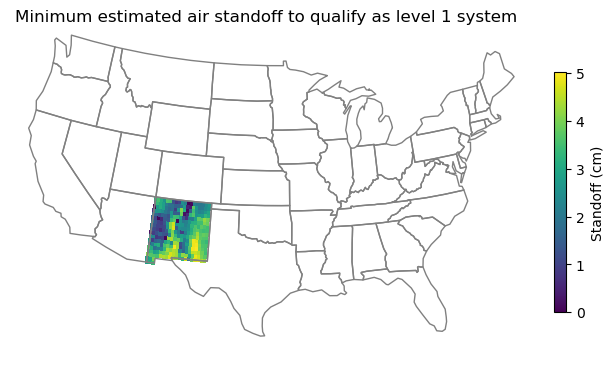

In [9]:
fig, ax = pvdeg.geospatial.plot_USA(
    standoff_res["x"],
    cmap="viridis",
    vmin=0,
    vmax=None,
    title="Minimum estimated air standoff to qualify as level 1 system",
    cb_title="Standoff (cm)",
)

# Relative Humidity Example - Time dimension

In [10]:
# State bar of new mexico: (35.16482, -106.58979)

weather_db = "NSRDB"
weather_id = (35.16482, -106.58979)  # NREL (39.741931, -105.169891)
weather_arg = {
    "satellite": "Americas",
    "names": 2022,
    "NREL_HPC": True,
    "attributes": [
        "air_temperature",
        "wind_speed",
        "dhi",
        "ghi",
        "dni",
        "relative_humidity",
    ],
}

weather_df, meta = pvdeg.weather.get(
    weather_db, weather_id, geospatial=False, **weather_arg
)

In [11]:
RH_module = pvdeg.humidity.module(weather_df=weather_df, meta=meta)

In [12]:
RH_module

,RH_surface_outside,RH_front_encap,RH_back_encap,RH_backsheet
2022-01-01 00:00:00+00:00,71.649999,33.488933,71.649999,71.649999
2022-01-01 00:30:00+00:00,74.709997,34.015967,72.822033,73.766015
2022-01-01 01:00:00+00:00,80.609993,34.644292,74.309248,77.459620
2022-01-01 01:30:00+00:00,81.749990,34.826528,74.853744,78.301867
2022-01-01 02:00:00+00:00,86.209989,35.009989,75.484062,80.847025
...,...,...,...,...
2022-12-31 21:30:00+00:00,24.496528,22.557621,32.547402,28.521965
2022-12-31 22:00:00+00:00,35.408019,25.623065,36.901667,36.154843
2022-12-31 22:30:00+00:00,41.934566,27.303453,39.421103,40.677834
2022-12-31 23:00:00+00:00,50.667706,29.165310,42.389185,46.528446


<Axes: >

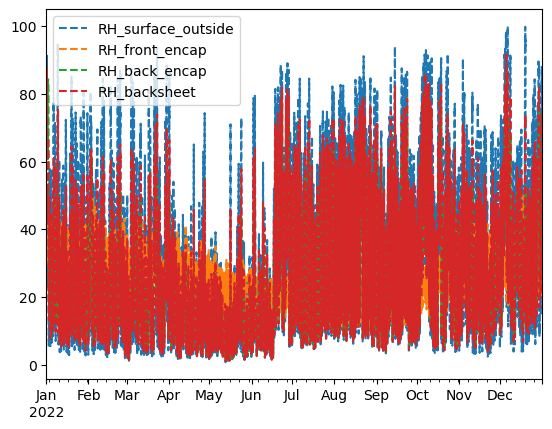

In [13]:
RH_module.plot(ls="--")

In [14]:
geo = {
    "func": pvdeg.humidity.module,
    "weather_ds": weather_NM_sub,
    "meta_df": meta_NM_sub,
}

RH_module = pvdeg.geospatial.analysis(**geo)

In [15]:
RH_module

<xarray.Dataset> Size: 192MB
Dimensions:             (latitude: 18, longitude: 19, time: 17520)
Coordinates:
  * latitude            (latitude) float32 72B 31.37 31.69 32.01 ... 36.49 36.81
  * longitude           (longitude) float32 76B -109.0 -108.7 ... -103.6 -103.3
  * time                (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31...
Data variables:
    RH_backsheet        (time, latitude, longitude) float64 48MB 78.08 ... 26.54
    RH_surface_outside  (time, latitude, longitude) float64 48MB 78.08 ... 32.15
    RH_front_encap      (time, latitude, longitude) float64 48MB 35.98 ... 29.46
    RH_back_encap       (time, latitude, longitude) float64 48MB 78.08 ... 20.93

In [16]:
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# import matplotlib.animation as animation
# import datetime
# ims = []
# for n in range(1, 13):
#     for i, np_t in enumerate(RH_module.time):
#         t = pd.Timestamp(np_t.values).time()
#         d = pd.Timestamp(np_t.values).day
#         m = pd.Timestamp(np_t.values).month
#         if m == n:
#             if d == 15:
#                 if t == datetime.time(12):
#                     fig, ax = pvdeg.geospatial.plot_USA(RH_module['RH_surface_outside'].sel(time=np_t),
#                             cmap='viridis', vmin=0, vmax=100,
#                             title=f'RH_surface_outside  - 2022-{m}-{d} 12:00',
#                             cb_title='Relative humidity (%)')
#                     plt.savefig(f'./images/RH_animation_{n}.png', dpi=600)

# import imageio
# ims = [imageio.imread(f'./images/RH_animation_{n}.png') for n in range(1, 13)]
# imageio.mimwrite(f'./images/RH_animation.gif', ims, format='GIF', duration=1000, loop=10)

![PVDeg Logo](./images/RH_animation.gif)